In [74]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from ydata_profiling import ProfileReport

%matplotlib inline

In [3]:
xls = pd.ExcelFile("Precios-Promedio-Nacionales-Diarios-2024-3.xlsx")

prices_data_2024 = pd.read_excel(xls, sheet_name="2024", index_col=[0], header=[0,1], skiprows=7, skipfooter=3)
prices_data_2024.columns = prices_data_2024.columns.map(' '.join)
prices_data_2024.rename_axis("Fecha").reset_index()

prices_data_2023 = pd.read_excel(xls, sheet_name="2023", index_col=[0], header=[0,1], skiprows=7, skipfooter=3)
prices_data_2023.columns = prices_data_2024.columns
prices_data_2023.rename_axis("Fecha").reset_index()

prices_data_2022 = pd.read_excel(xls, sheet_name="2022", index_col=[0], header=[0,1], skiprows=6, skipfooter=3)
prices_data_2022.columns = prices_data_2023.columns
prices_data_2022.rename_axis("Fecha").reset_index()

prices_data_2021 = pd.read_excel(xls, sheet_name="2021", index_col=[0], header=[0,1], skiprows=6, skipfooter=3)
prices_data_2021.columns = prices_data_2022.columns
prices_data_2021.rename_axis("Fecha").reset_index()

prices_data = pd.concat([prices_data_2021, prices_data_2022, prices_data_2023, prices_data_2024])
prices_data.drop(columns=["Tipo de Cambio GTQ/USD", "Bunker GTQ/GALON"], axis=1, inplace=True)

prices_report = ProfileReport(prices_data, explorative=True)
prices_report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

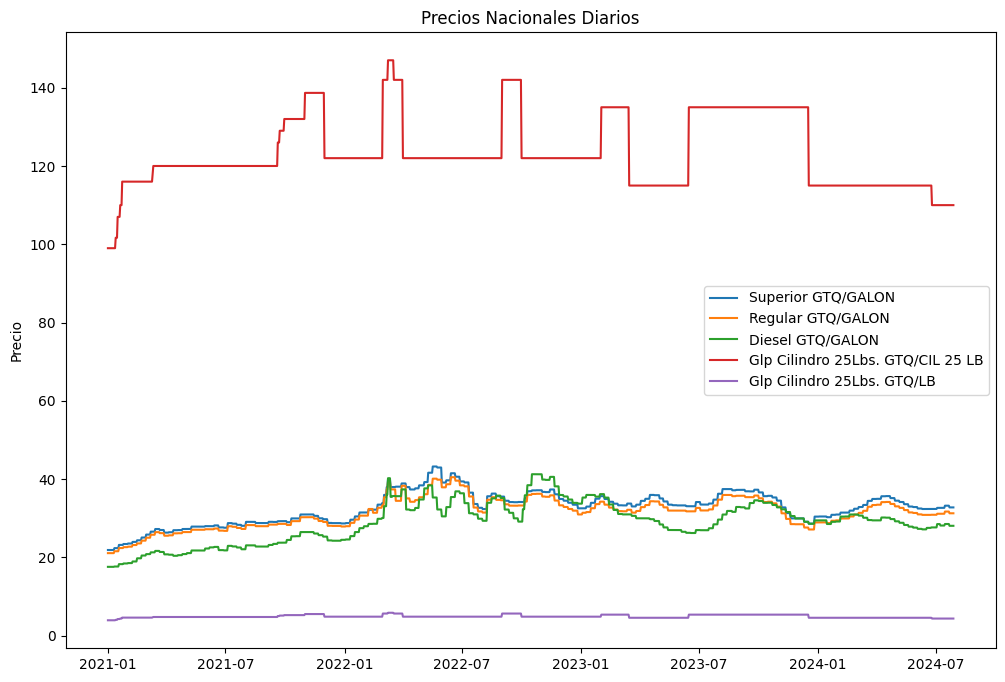

In [4]:
plt.figure(figsize=(12, 8))
for column in prices_data.columns:
    plt.plot(prices_data[column], label=f"{column}")

plt.ylabel("Precio")
plt.title(f'Precios Nacionales Diarios')
plt.legend()
plt.show()

/tmp/ipykernel_1398/1829677026.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


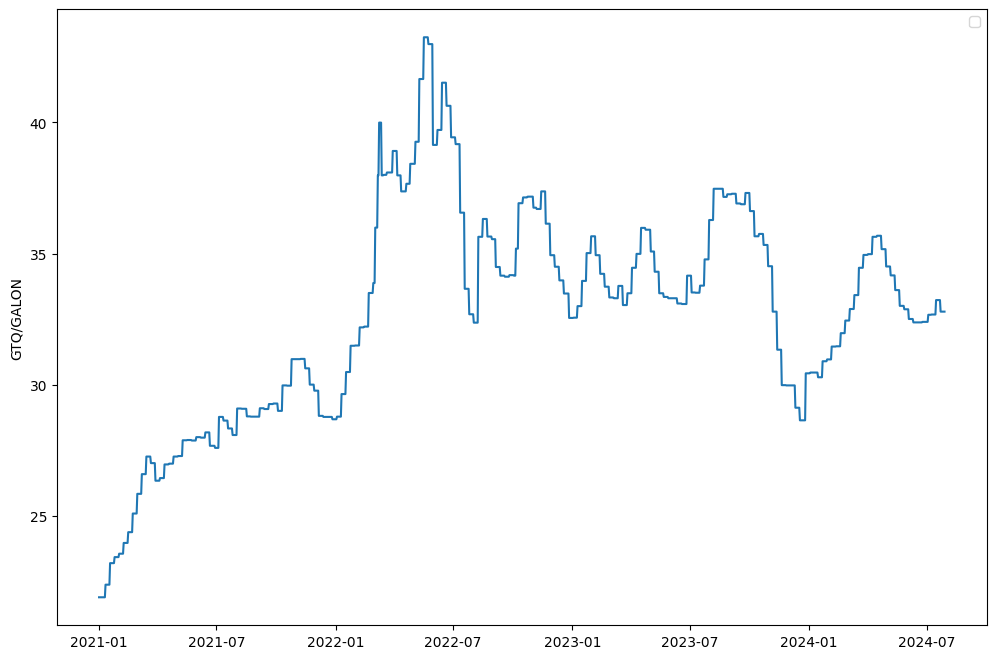

In [5]:
super_prices = prices_data["Superior GTQ/GALON"].dropna()

plt.figure(figsize=(12,8))
plt.plot(super_prices)
plt.ylabel('GTQ/GALON')
plt.legend()
plt.show()

In [6]:
inicio = min(super_prices.index)
valor = super_prices.loc[inicio]
print(f"Inicio: {inicio} | Valor: {valor}")

fin = max(super_prices.index)
valor = super_prices.loc[fin]
print(f"Final: {fin} | Valor: {valor}")

infer_freq = pd.infer_freq(super_prices.index)
print(f"Frecuencia: {infer_freq}")

Inicio: 2021-01-01 00:00:00 | Valor: 21.91
Final: 2024-07-28 00:00:00 | Valor: 32.79
Frecuencia: None


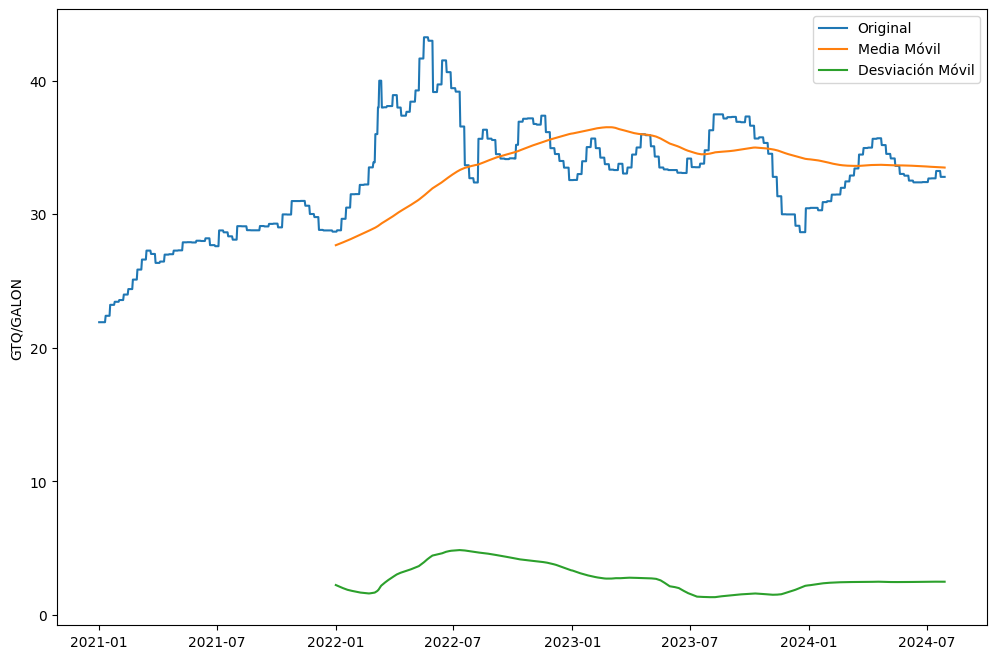

In [33]:
# Se calcula la media móvil y la desviación estandar móvil de los últimos 90 días.
mediaMovil = super_prices.rolling(window=365).mean()
deMovil = super_prices.rolling(window=365).std()


# Plot original data
plt.figure(figsize=(12, 8))
plt.plot(super_prices, label='Original')
plt.plot(mediaMovil, label='Media Móvil')
plt.plot(deMovil, label='Desviación Móvil')

plt.ylabel('GTQ/GALON')
plt.legend()
plt.show()

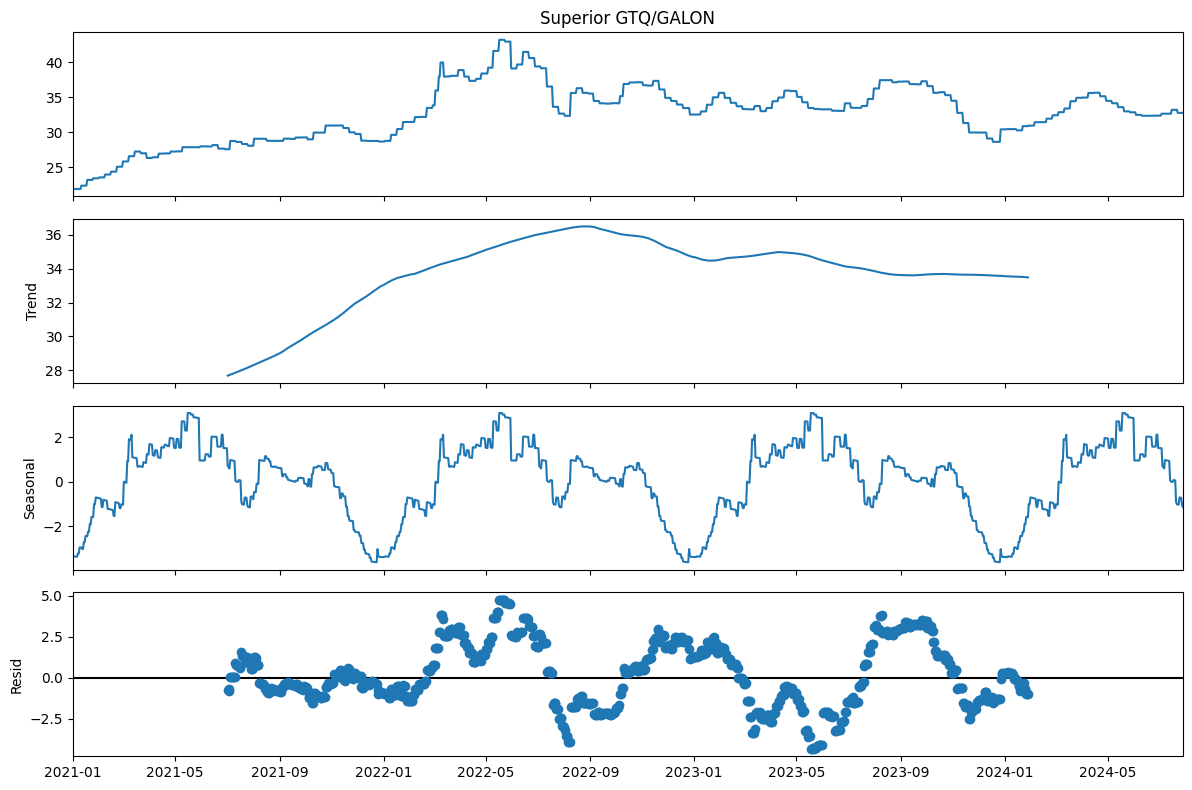

In [69]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(12, 8))
    descomposicion = seasonal_decompose(super_prices, period=365)
    descomposicion.plot()

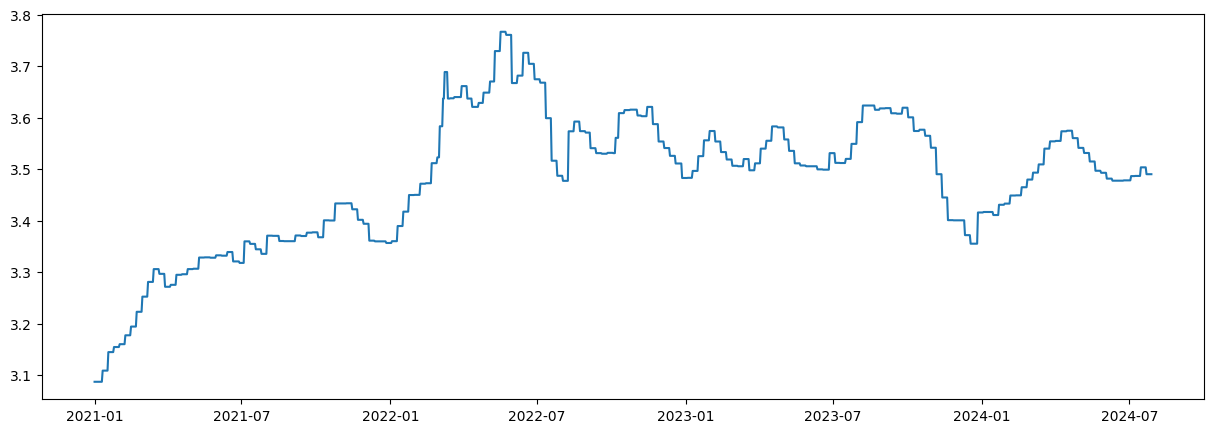

In [91]:
super_prices_log = np.log(super_prices)
plt.plot(super_prices_log)

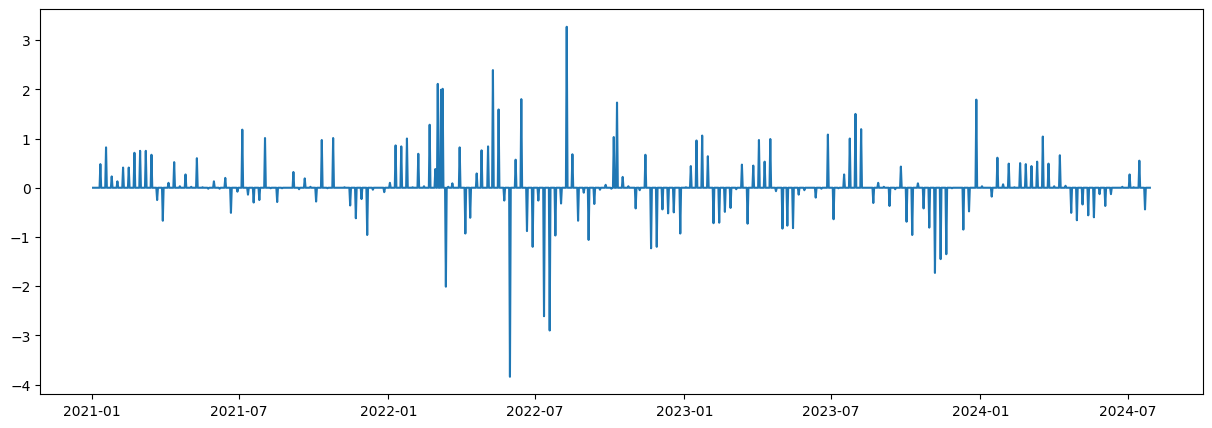

In [95]:
super_prices_diff = super_prices.diff()
super_prices_diff.dropna(inplace=True)
plt.plot(super_prices_diff)

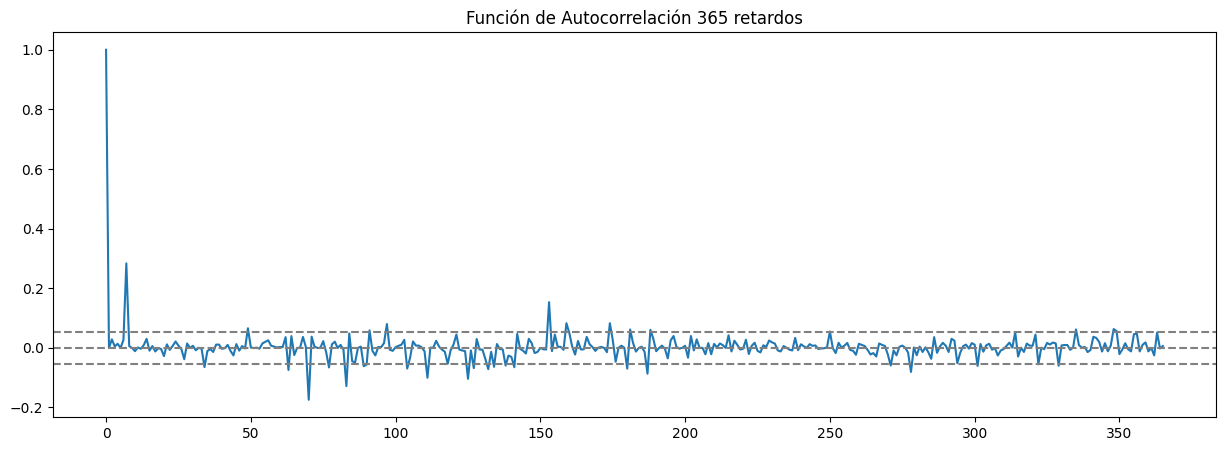

In [96]:
plt.plot(acf(super_prices_diff, nlags=365))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(super_prices)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(super_prices)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación 365 retardos')

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100

In [53]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(super_prices, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba          -2.938738
p-value                         0.041025
# de retardos usados            7.000000
# de observaciones usadas    1294.000000
Critical Value (1%)            -3.435414
Critical Value (5%)            -2.863776
Critical Value (10%)           -2.567961
dtype: float64


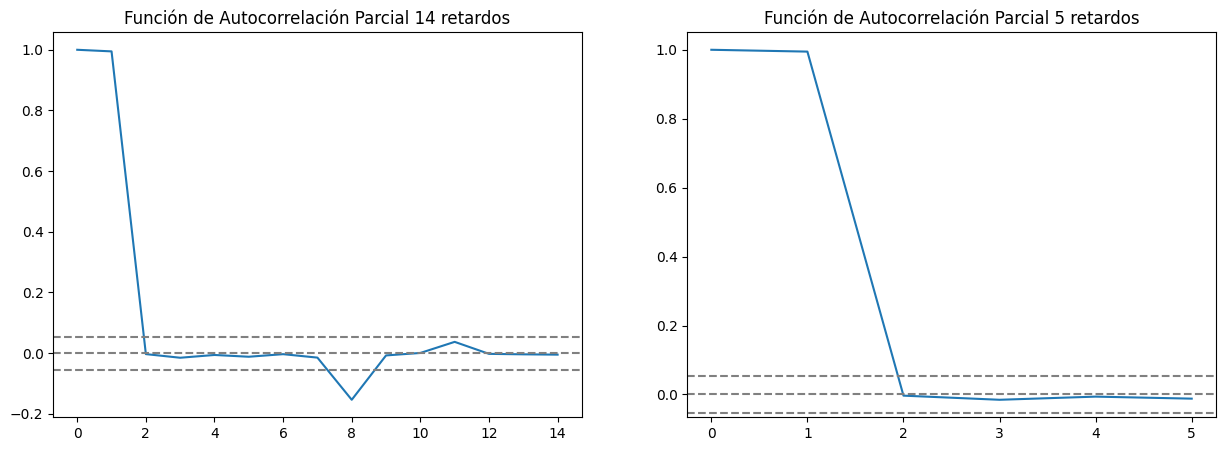

In [93]:
plt.subplot(121)
plt.plot(pacf(super_prices, nlags=14))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(super_prices)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(super_prices)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 14 retardos')

plt.subplot(122)
plt.plot(pacf(super_prices, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(super_prices)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(super_prices)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 retardos')

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100

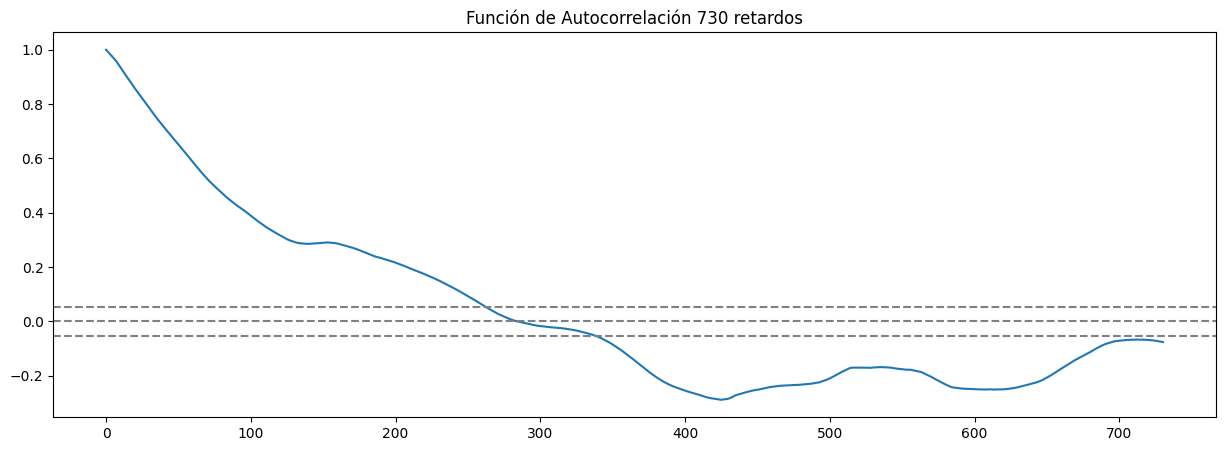

In [100]:
plt.plot(acf(super_prices, nlags=730))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(super_prices)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(super_prices)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación 730 retardos')

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100

In [87]:
super_prices_train = super_prices[:"2023-12-30"]
super_prices_train

2021-01-01    21.91
2021-01-02    21.91
2021-01-03    21.91
2021-01-04    21.91
2021-01-05    21.91
              ...  
2023-12-26    28.65
2023-12-27    30.44
2023-12-28    30.44
2023-12-29    30.44
2023-12-30    30.44
Name: Superior GTQ/GALON, Length: 1092, dtype: float64

In [90]:
model111 = ARIMA(super_prices_train, order=(1, 0, 1), enforce_stationarity=False, enforce_invertibility=False)
resultado_m111 = model111.fit()
print(resultado_m111.summary().tables[1])

/home/darielvr/Escritorio/Data/Laboratorio2/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/darielvr/Escritorio/Data/Laboratorio2/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/darielvr/Escritorio/Data/Laboratorio2/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         34.0091      2.031     16.742      0.000      30.028      37.991
ar.L1          0.9944      0.004    271.685      0.000       0.987       1.002
ma.L1      -5.091e-05      0.442     -0.000      1.000      -0.866       0.865
sigma2         0.1208      0.001     89.993      0.000       0.118       0.123
